In [117]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from albumentations.pytorch import ToTensorV2
from dataset_split import create_train_valid_split
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from torchvision import datasets



In [118]:
def load_data(data_augmentation=False):
    transforms_original = transforms.Compose([
        v2.Resize((224,224)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    transforms_augmented = transforms.Compose([
        v2.Resize((224,224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomRotation(10),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.4)),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    
    if data_augmentation:
        train_orig_dataset = datasets.ImageFolder(root=r'brain_tumor_cnn\tumors_dataset_split\train',transform=transforms_original)
        train_aug_dataset = datasets.ImageFolder(root=r'brain_tumor_cnn\tumors_dataset_split\train',transform=transforms_augmented)
        train_dataset = torch.utils.data.ConcatDataset([train_orig_dataset, train_aug_dataset])
    else:
        train_dataset = datasets.ImageFolder(root=r'brain_tumor_cnn\tumors_dataset_split\train',transform=transforms_original)
        
    valid_dataset = datasets.ImageFolder(root=r'brain_tumor_cnn\tumors_dataset_split\valid',transform=transforms_original)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)

    return train_loader, valid_loader

In [119]:
train_loader,valid_loader = load_data(data_augmentation=True)
print(train_loader)

In [120]:
"""
def show_MRI_batch(dataloader, title="Batch of MRI Tumor Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting
            ax.imshow(img)
            ax.set_title(MRI.classes[labels[i]])
            ax.axis('off')
    plt.show()
    
show_MRI_batch(MRI_train_loader)
"""

'\ndef show_MRI_batch(dataloader, title="Batch of MRI Tumor Images"):\n    images, labels = next(iter(dataloader))\n    fig, axes = plt.subplots(4, 8, figsize=(15, 8))\n    fig.suptitle(title)\n    \n    for i, ax in enumerate(axes.flatten()):\n        if i < len(images):\n            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting\n            ax.imshow(img)\n            ax.set_title(MRI.classes[labels[i]])\n            ax.axis(\'off\')\n    plt.show()\n    \nshow_MRI_batch(MRI_train_loader)\n'

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [122]:
# Load the pre-trained MobileNetV3 model
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = mobilenet_v3_small(weights=weights)
print(model)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [123]:
# Freeze all layers except the classifier
for param in model.features.parameters():
    param.requires_grad = False

# Change the number of output classes   
num_classes = 3 
model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=num_classes)

model = model.to(device)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [124]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [125]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step() # update weights

            # Calculate accuracy
            _, predicted = outputs.max(1) # return max value and index
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()  # .item() is used to convert the result of .sum() into a regular Python integer.
            running_loss += loss.item()
            
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
                      f'Loss: {running_loss / 100:.4f}, Accuracy: {100.0 * correct / total:.2f}%')

def test_model(model, test_loader):
    model.eval()  
    correct = 0
    total = 0
    test_loss = 0  # Accumulate loss over all batches
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()  # Accumulate batch loss
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)  # Average loss over all batches
    accuracy = 100.0 * correct / total
    
    # Print results
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy

In [126]:
num_epochs =50
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/50], Loss: 0.7580, Accuracy: 64.62%
Epoch [2/50], Loss: 0.5356, Accuracy: 78.72%
Epoch [3/50], Loss: 0.4557, Accuracy: 81.49%
Epoch [4/50], Loss: 0.4289, Accuracy: 82.19%
Epoch [5/50], Loss: 0.4081, Accuracy: 81.60%
Epoch [6/50], Loss: 0.3880, Accuracy: 83.75%
Epoch [7/50], Loss: 0.3644, Accuracy: 84.13%
Epoch [8/50], Loss: 0.3628, Accuracy: 84.17%
Epoch [9/50], Loss: 0.3335, Accuracy: 85.62%
Epoch [10/50], Loss: 0.3359, Accuracy: 85.52%
Epoch [11/50], Loss: 0.3184, Accuracy: 86.25%
Epoch [12/50], Loss: 0.3200, Accuracy: 86.70%
Epoch [13/50], Loss: 0.3155, Accuracy: 86.98%
Epoch [14/50], Loss: 0.3070, Accuracy: 86.67%
Epoch [15/50], Loss: 0.2841, Accuracy: 87.50%
Epoch [16/50], Loss: 0.2897, Accuracy: 87.81%
Epoch [17/50], Loss: 0.2833, Accuracy: 87.85%
Epoch [18/50], Loss: 0.2814, Accuracy: 87.92%
Epoch [19/50], Loss: 0.2720, Accuracy: 88.40%
Epoch [20/50], Loss: 0.2653, Accuracy: 88.72%
Epoch [21/50], Loss: 0.2686, Accuracy: 88.72%
Epoch [22/50], Loss: 0.2700, Accuracy: 88.4

In [127]:
test_model(model, valid_loader)

Test Loss: 0.2157, Test Accuracy: 91.67%


(0.21571642044000328, 91.66666666666667)

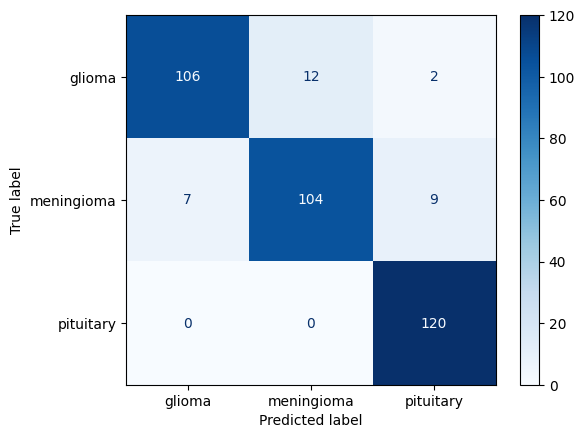

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.88      0.91       120
  meningioma       0.90      0.87      0.88       120
   pituitary       0.92      1.00      0.96       120

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360



In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
class_names = ['glioma', 'meningioma', 'pituitary']
true_labels = []
predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

In [130]:
torch.save(model.state_dict(), 'brain_tumor_classifier.pth')